In [7]:
import numpy as np
#import arviz as az
# import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.stats import mode
from scipy.interpolate import griddata
from sklearn.metrics import adjusted_rand_score
import pandas as pd
from math import sqrt

import sys
sys.path.append('./pp_mix')

import pp_mix.protos.py.params_pb2 as params_pb2

from pp_mix.interface import cluster_estimate
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import MultivariateMixtureState, EigenVector, EigenMatrix
from pp_mix.protos.py.params_pb2 import Params

ModuleNotFoundError: No module named 'pp_mix.protos.py'

# Read the dataset and build data


In [10]:
df = pd.read_excel("data/Eyes_data/41598_2021_2025_MOESM2_ESM.xlsx")
# extract only right eyes (OD)
df_od = df.loc[df['Masked_Id_Age1'].str.contains("OD", case=True)].set_index('Masked_Id_Age1')
# clustering obtained by cifu (method used in the paper)
cifu_clustering = df_od['Cluster_Id_Age1']

# THIS IS THE DATA USED IN THE ALGORITHM, THEN CONVERTED TO NUMPY ARRAY
df_od = df_od[df_od.columns[1:]]
# NUMPY ARRAY OF DATA
data = df_od.to_numpy()

# Read the chain and the acceptance rates

In [2]:
chain = loadChains("data/Eyes_data/chains/chain_1.recordio", MultivariateMixtureState)
acc_rates = np.loadtxt("data/Eyes_data/acc_rates/acc_rates_chain_1.csv", delimiter=',')


# Check chain mixing on some representative variables


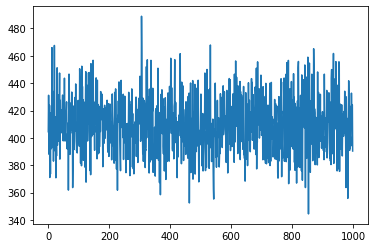

In [3]:
tau_chain = np.array([x.lamb_block.tau for x in chain])
plt.plot(tau_chain)
plt.title("tau chain")


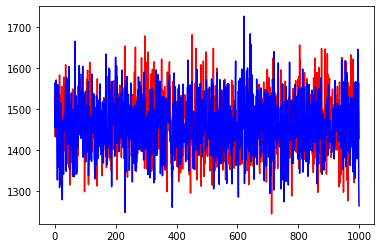

In [4]:
first_sbar_chain = np.array([to_numpy(x.sigma_bar)[0] for x in chain])
plt.plot(first_sbar_chain,color='red')

last_sbar_chain = np.array([to_numpy(x.sigma_bar)[-1] for x in chain])
plt.plot(last_sbar_chain,color='blue')

plt.title("sbar_chain")

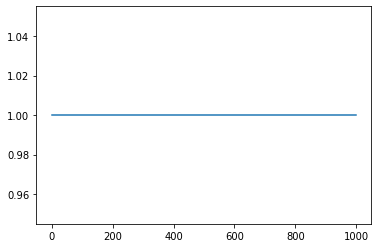

In [6]:
n_cluster_chain = np.array([x.ma for x in chain])
plt.plot(n_cluster_chain)

plt.title("number of clusters chain")

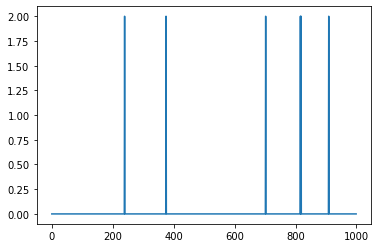

In [7]:
n_nonall_chain = np.array([x.mna for x in chain])
plt.plot(n_nonall_chain)

plt.title("number of non allocated components chain")

# Summarize estimated quantities


In [14]:
post_mode_nclus = mode(n_cluster_chain)[0][0] # store in dataframe
post_avg_nclus = n_cluster_chain.mean() # store in dataframe
post_avg_nonall =  n_nonall_chain.mean() # store in dataframe

clus_alloc_chain = [x.clus_alloc for x in chain]
best_clus = cluster_estimate(np.array(clus_alloc_chain))
n_clus_best_clus = np.size(np.unique(best_clus))

true_clus = cifu_clustering.to_numpy()
ari_best_clus = adjusted_rand_score(true_clus, best_clus) # store in dataframe

aris_chain = np.array([adjusted_rand_score(true_clus, x) for x in clus_alloc_chain])
mean_aris, sigma_aris = np.mean(aris_chain), np.std(aris_chain) # store mean_aris in dataframe
CI_aris = norm.interval(0.95, loc=mean_aris, scale=sigma_aris/sqrt(len(aris_chain))) # store in dataframe

list_performance = list()

list_performance.append([acc_rates[0],acc_rates[1],post_mode_nclus,
                    post_avg_nclus, post_avg_nonall, ari_best_clus, CI_aris])
        
        
df_performance = pd.DataFrame(list_performance, columns=('means_ar','lambda_ar',
                                      'mode_nclus', 'avg_nclus', 'avg_nonalloc', 'ari_best_clus', 'CI_aris'))
    

/home/lorenzo/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/lorenzo/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [15]:
display(df_performance)

,means_ar,lambda_ar,mode_nclus,avg_nclus,avg_nonalloc,ari_best_clus,CI_aris
0,0.396121,0.220463,1,1.0,0.012,0.0,"(nan, nan)"


# Plot of the clusters of the estimated clustering

In [16]:
theta = np.linspace(0, 2 * np.pi, data.shape[1])
dx = theta[1] - theta[0]

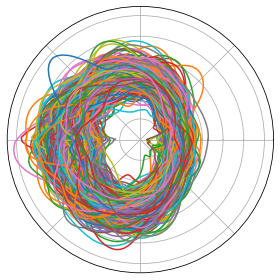

In [18]:
fig = plt.figure()

for i in range(n_clus_best_clus):
    ax = fig.add_subplot(int(sqrt(n_clus_best_clus)),int(sqrt(n_clus_best_clus)),i+1, polar=True)

    ax.plot(theta, data[best_clus == i,:].T)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()  
plt.show()